# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 30.8 MB 28.8 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import math


from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3501,1,44.0,48800.0,1,1
158,0,26.0,26800.0,2,0
542,0,21.0,37700.0,3,0
4950,1,29.0,42100.0,4,0
2591,1,45.0,51000.0,2,1
97,1,23.0,31500.0,1,0
3546,1,41.0,38300.0,2,0
2676,0,25.0,54900.0,3,0
1314,0,22.0,47700.0,0,0
1909,1,27.0,29200.0,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
features = ['age', 'income']
df[features] = df[features].astype('int')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              5000 non-null   int64
 1   age                 5000 non-null   int64
 2   income              5000 non-null   int64
 3   family_members      5000 non-null   int64
 4   insurance_benefits  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

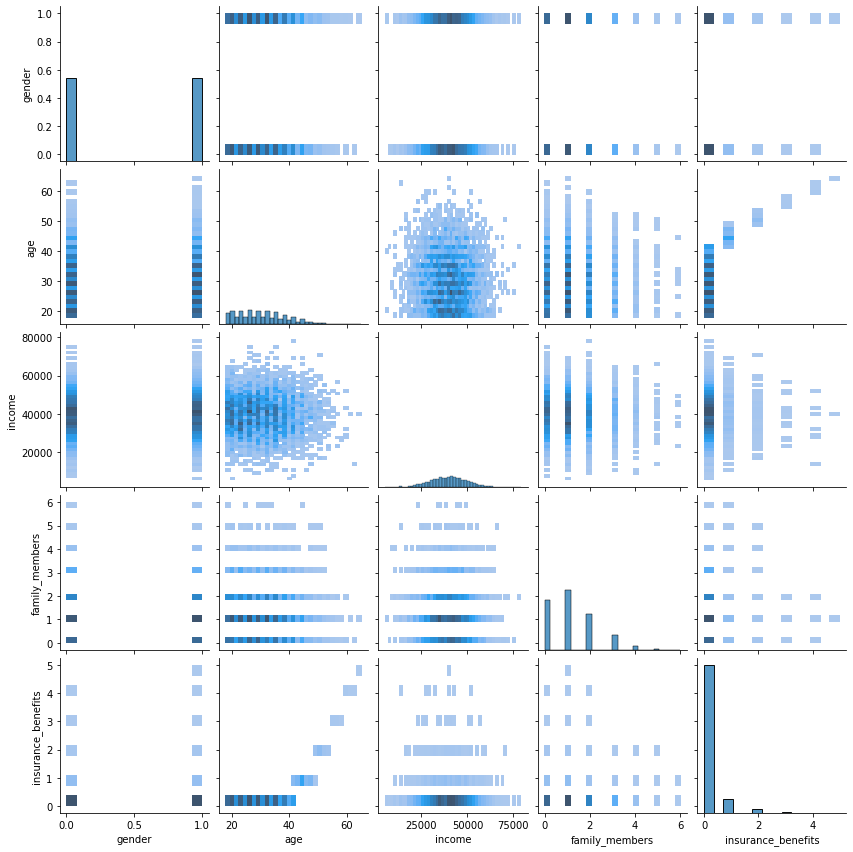

In [9]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    np.random.seed(42)
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [13]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3443,0.0,0.400000,0.506329,0.333333,0
1432,1.0,0.323077,0.522785,0.166667,0
436,0.0,0.507692,0.469620,0.166667,0
4915,0.0,0.292308,0.477215,0.166667,0
7,1.0,0.384615,0.488608,0.666667,0


Now, let's get similar records for a given one for every combination

In [14]:
def check_knn_results(df, k, n, scaling='Scaled', metrics=[]):
    """
    Helper fucnction
    """
    for metric in metrics:
        print('{} results for {}'.format(scaling, metric))
        print('-'*50)
        print(get_knn(df, n, k, metric))
        print()

In [15]:
# reset the indices as the results with .loc and .iloc
# don't line up
df = df.reset_index(drop=True)

In [16]:
# for insured member 100. Without scaling
metrics = ['euclidean', 'manhattan']
check_knn_results(df[feature_names], k=5, n=100, scaling='Unscaled')

In [17]:
# reset the indices as the results with .loc and .iloc
# don't line up
df_scaled = df_scaled.reset_index(drop=True)

In [18]:
# for insured member 100. With scaling
metrics = ['euclidean', 'manhattan']
check_knn_results(df_scaled[feature_names], k=5, n=100, metrics=metrics)

Scaled results for euclidean
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4915     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1323     0.0  0.292308  0.456962        0.166667  0.015190
811      0.0  0.307692  0.470886        0.166667  0.015437

Scaled results for manhattan
--------------------------------------------------
      gender       age    income  family_members  distance
100      0.0  0.292308  0.472152        0.166667  0.000000
4915     0.0  0.292308  0.477215        0.166667  0.005063
243      0.0  0.292308  0.467089        0.166667  0.005063
1323     0.0  0.292308  0.456962        0.166667  0.015190
811      0.0  0.307692  0.470886        0.166667  0.016650



**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, without scaling, the distance metrics both, euclidean and manhattan are affected by income, which is on a different scale compared with the other features.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

There are some differences between the metrics irregardless of scaling. Euclidean penalizes large values more than Manhattan. This is shows in the 5th neighbor in both results.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In [19]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0.5).astype(np.uint8)

In [20]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()


0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [22]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [30]:
train, valid = \
(
    train_test_split(df, stratify=df['insurance_benefits_received'], test_size=0.3, random_state=42)
)
features_train, target_train = train[feature_names], train['insurance_benefits_received']
features_valid, target_valid = valid[feature_names], valid['insurance_benefits_received']


In [31]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape


((3500, 4), (3500,), (1500, 4), (1500,))

In [32]:
def build_model(train, target, test, n_neighbors):
    """
    Fit a model and make predictions
    """
    np.random.seed(42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(features_train, target)
    y_pred = model.predict(test)
    return y_pred

In [33]:
n_neighbors = 10
# using unscaled data
for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.60
Confusion Matrix
[[0.87066667 0.01666667]
 [0.05733333 0.05533333]]

For neighbor k=2
F1: 0.33
Confusion Matrix
[[0.88       0.00733333]
 [0.08866667 0.024     ]]

For neighbor k=3
F1: 0.34
Confusion Matrix
[[0.87466667 0.01266667]
 [0.08666667 0.026     ]]

For neighbor k=4
F1: 0.22
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [9.86666667e-02 1.40000000e-02]]

For neighbor k=5
F1: 0.26
Confusion Matrix
[[0.88266667 0.00466667]
 [0.09533333 0.01733333]]

For neighbor k=6
F1: 0.09
Confusion Matrix
[[0.88733333 0.        ]
 [0.10733333 0.00533333]]

For neighbor k=7
F1: 0.10
Confusion Matrix
[[0.886      0.00133333]
 [0.10666667 0.006     ]]

For neighbor k=8
F1: 0.03
Confusion Matrix
[[0.88733333 0.        ]
 [0.11066667 0.002     ]]

For neighbor k=9
F1: 0.05
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [1.10000000e-01 2.66666667e-03]]

For neighbor k=10
F1: 0.02
Confusion Matrix
[[0.88733333 0.        ]
 [0.11133333 0.00133333]]



In [34]:
df_scaled['insurance_benefits_received'] = (df_scaled['insurance_benefits'] > 0).astype(int)


In [36]:
train, valid = \
(
    train_test_split(df_scaled, stratify=df_scaled['insurance_benefits_received'], test_size=0.3, random_state=42)
)

transforms = sklearn.preprocessing.MaxAbsScaler().fit(features_train)


In [37]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape


((3500, 4), (3500,), (1500, 4), (1500,))

In [38]:
for k in range(1, n_neighbors+1):
    y_pred = build_model(features_train, target_train, features_valid, k)
    print('For neighbor k={}'.format(k))
    eval_classifier(target_valid, y_pred)
    print()

For neighbor k=1
F1: 0.60
Confusion Matrix
[[0.87066667 0.01666667]
 [0.05733333 0.05533333]]

For neighbor k=2
F1: 0.33
Confusion Matrix
[[0.88       0.00733333]
 [0.08866667 0.024     ]]

For neighbor k=3
F1: 0.34
Confusion Matrix
[[0.87466667 0.01266667]
 [0.08666667 0.026     ]]

For neighbor k=4
F1: 0.22
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [9.86666667e-02 1.40000000e-02]]

For neighbor k=5
F1: 0.26
Confusion Matrix
[[0.88266667 0.00466667]
 [0.09533333 0.01733333]]

For neighbor k=6
F1: 0.09
Confusion Matrix
[[0.88733333 0.        ]
 [0.10733333 0.00533333]]

For neighbor k=7
F1: 0.10
Confusion Matrix
[[0.886      0.00133333]
 [0.10666667 0.006     ]]

For neighbor k=8
F1: 0.03
Confusion Matrix
[[0.88733333 0.        ]
 [0.11066667 0.002     ]]

For neighbor k=9
F1: 0.05
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [1.10000000e-01 2.66666667e-03]]

For neighbor k=10
F1: 0.02
Confusion Matrix
[[0.88733333 0.        ]
 [0.11133333 0.00133333]]



1. Comparing KNN between unscaled/scaled data shows a huge difference in the F1 score. 
The lowest F1 score produced by any model using scaled features is 89%. Clearly, showing how the use of distance metric during fitting impacts predictions by large valued features - in this case income.



# Task 3. Regression (with Linear Regression)

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([X.shape[0], 1]), X, axis=1)
        y_pred = np.dot(X2, self.weights)
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [ ]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

66% of the variance is explained by the features when the data is not scaled.

There is no difference in either the RMSE/R2 score after scaling. 

Linear Regression makes predictions using the units of the output, making necessary adjustments to the units of the features.

# Task 4. Obfuscating Data

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [ ]:
np.dot(P, np.linalg.inv(P))


In [ ]:
np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))


In [ ]:
np.dot(X, P)


Can you guess the customers' ages or income after the transformation?

No, the data is unreadable.


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

$X'$ $P^{-1}$ = ($X$$P$)$P^{-1}$ = $X$($P$$P^{-1}$) 

In [ ]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()


In [ ]:
# original data
pd.DataFrame(X, columns=feature_names).head()

In [ ]:
# transformed one
pd.DataFrame(np.dot(X, P), columns=feature_names).head()

In [ ]:
pd.DataFrame(np.dot(X, np.dot(P, np.linalg.inv(P))), columns=feature_names).head()


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

The reason is due to floating point errors- there is a limited number of bits that are able to store real numbers.

## Proof That Data Obfuscation Can Work with LR

**Analytical proof**

Given equation:


$$
w_P = [(XP)^TXP]^{-1}(XP)^Ty
$$

By reversivity of the transpose of a product of matrices:


$$
w_P = [(XP)^TXP]^{-1}P^TX^Ty
$$

Rearranging the terms inside the square brackets:


$$
w_P = [P^TX^TXP]^{-1}P^TX^Ty
$$

Expanding the term inside the square brackets:


$$
w_P = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$

Using multiplicative identity:


$$
(P^T)^{-1}P^T = P^T(P^T)^{-1} = I
$$

The equation reduces to:


$$
w_P = P^{-1}(X^TX)^{-1}IX^Ty
$$

We notice:


$$
w = (X^TX)^{-1}X^Ty
$$

Substitute 'w' in the above equation:


$$ 
w_p = P^{-1}w
$$

We are aware that:


$$ y = Xw $$

The prediction of:


$$ y_p = X _pw_p $$

Replace:

$$ w_p $$

In the above equation:


$$ y_p = X_p(P^{-1}w) $$

From obsfuscating the input X:


$$ X_p = XP $$

Subsititute this in the above equation:


$$ yp = XPP^{-1}w $$

From multiplicative identity:


$$ (P^T)^{-1}P^T = P^T(P^T)^{-1} = I $$

What's remaining:


$$ y = y_p = Xw $$

The analytical proof shows that the there should be no impact to the quality of regression.

## Test Linear Regression With Data Obfuscation

In [ ]:
def generate_square_matrix(num_features, seed=42):
    """
    Generate a square matrix from a uniform distribution
    """
    rng = np.random.default_rng(seed=seed)
    return rng.random(size=(num_features, num_features))

In [ ]:
P = generate_square_matrix(4, seed=1234)


In [ ]:
def is_invertible(P):
    """
    Check if P is invertible or not
    """
    return np.allclose(np.dot(P, np.linalg.inv(P)), np.dot(np.linalg.inv(P), P))

In [ ]:
is_invertible(P)


Original data, obfuscated:


In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Scaled data, obfuscated:


In [ ]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(np.dot(X, P), y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

# Conclusions

The results show that  after obfuscating the data, the RMSE/R2 score from the Linear Regression model are the same; independent of if data is scaled or not.



## Summary

We used KNN to find the a customer close to a given customer; the solution was improved by:
- Scaling the data 
- Leveraging the Euclidean metric to improve predictions

We have also built model(s) to help the marketing team predict whether a customer will likely receive insurance benefits or not.  The resulting model produced had an F1 score of 92% on the validation set.

We have also built a LinearRegression model on both scaled and unscaled data that would predict the number of insurance benefits a new customer would receive: 
- Model produced a moderately high R2 score 66%
- Made the observation is that scaling didn't impact the result(s)

We obfuscated the data, and displayed analytically that there is no difference between the obfuscated & original data.

We also proved this computationally:
- Built a LinearRegression model with obfuscated data
- The resulting RMSE & R2 scores were identical to that obtained with the original data